In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import resultcomp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import plots
import json
import numpy as np
import os
mpl.rcParams['figure.dpi'] = 300
results_dir = './../../results'

In [51]:
region = 'netherlands'

In [52]:
if region == 'netherlands':
    start = 'netherlands-20200518_235511'
    end = 'netherlands-baseline'
else:
    start = 'saopaulo-20200518_170056'
    end = 'saopaulo-baseline'

In [53]:
def string_range(strings, start=None, end=None):
    keep = []
    include = False
    for string in strings:
        if string.startswith(start):
            include = True
        if include:
            keep.append(string)
        if end is not None and string.startswith(end):
            include = False
    return keep

In [54]:
result_directories = sorted(os.listdir(results_dir))
directories = string_range(result_directories, start, end)
df = pd.DataFrame(columns=['scale', 'directory', 'p', 'gamma', 'beta', 'mse'])

In [55]:
metrics = None
for d in directories:
    p = "{}/{}/distance-metrics.csv".format(results_dir, d)
    if not os.path.exists(p):
        continue
    s = pd.read_csv(p)
    s = s.assign(run_id=d).set_index(['run_id', 'distance'])
    if metrics is None:
        metrics = s
    else:
        metrics = pd.concat([metrics, s])

In [56]:
def mse(dms, df):
    sq_errs = np.square(np.subtract(dms['groundtruth_sum'], dms['model_sum']))
    for model in dms.index.get_level_values(level=0).unique():
        if model != region + '-baseline':
            with open(results_dir + '/' + model+ '/parameters.json') as f:
                d = json.load(f)
            
            df2 = pd.DataFrame({'directory': [model], 'p': [d['model']['p']], 'gamma': [d['model']['gamma']], 'beta': [d['model']['region_sampling']['beta']], 'mse': [sq_errs.loc[model].mean()]})
        else:
            df2 = pd.DataFrame({'directory': [model], 'p': [None], 'gamma': [None], 'beta': [None], 'mse': [sq_errs.loc[model].mean()]})
        df = df.append(df2)
    return df

In [57]:
df = pd.DataFrame(columns=['directory', 'p', 'gamma', 'beta', 'mse'])
df = mse(metrics, df).set_index('directory')

In [58]:
if region == 'saopaulo':
    df = df.drop('saopaulo-20200519_224039')
else:
    df = df.drop('netherlands-20200519_043353')

In [59]:
df.sort_values('mse')

,p,gamma,beta,mse
directory,,,,
netherlands-20200519_231349,0.6,0.45,0.04,0.000001
netherlands-20200520_002557,0.7,0.50,0.04,0.000001
netherlands-20200519_231327,0.7,0.45,0.04,0.000001
netherlands-20200520_002623,0.6,0.50,0.04,0.000002
netherlands-20200520_013329,0.7,0.55,0.04,0.000002
netherlands-20200519_231406,0.5,0.45,0.04,0.000002
netherlands-20200519_032021,0.3,0.20,0.04,0.000002
netherlands-20200519_043211,0.9,0.50,0.04,0.000002
netherlands-20200519_175741,0.5,0.55,0.03,0.000003


In [47]:
df_appendix = df.groupby(['p', 'gamma', 'beta']).sum()['mse'].reset_index().sort_values('mse')
df_appendix['mse_str'] = df_appendix['mse'].apply(lambda x: "{:.5e}".format(x))
df_appendix[['p', 'gamma', 'beta', 'mse_str']].to_clipboard(sep="&", excel=True, index=False)

In [48]:
df_appendix

,p,gamma,beta,mse,mse_str
40,0.7,0.50,0.05,0.000003,3.26645e-06
23,0.6,0.45,0.05,0.000003,3.39282e-06
30,0.6,0.55,0.04,0.000004,3.68847e-06
37,0.7,0.45,0.05,0.000004,3.77249e-06
13,0.5,0.50,0.04,0.000004,3.79316e-06
27,0.6,0.50,0.05,0.000004,3.85141e-06
43,0.7,0.55,0.05,0.000004,3.93623e-06
10,0.5,0.45,0.04,0.000004,4.01785e-06
16,0.5,0.55,0.04,0.000004,4.03181e-06
49,0.9,0.50,0.07,0.000004,4.05644e-06


Text(0.5, 1.02, 'B')

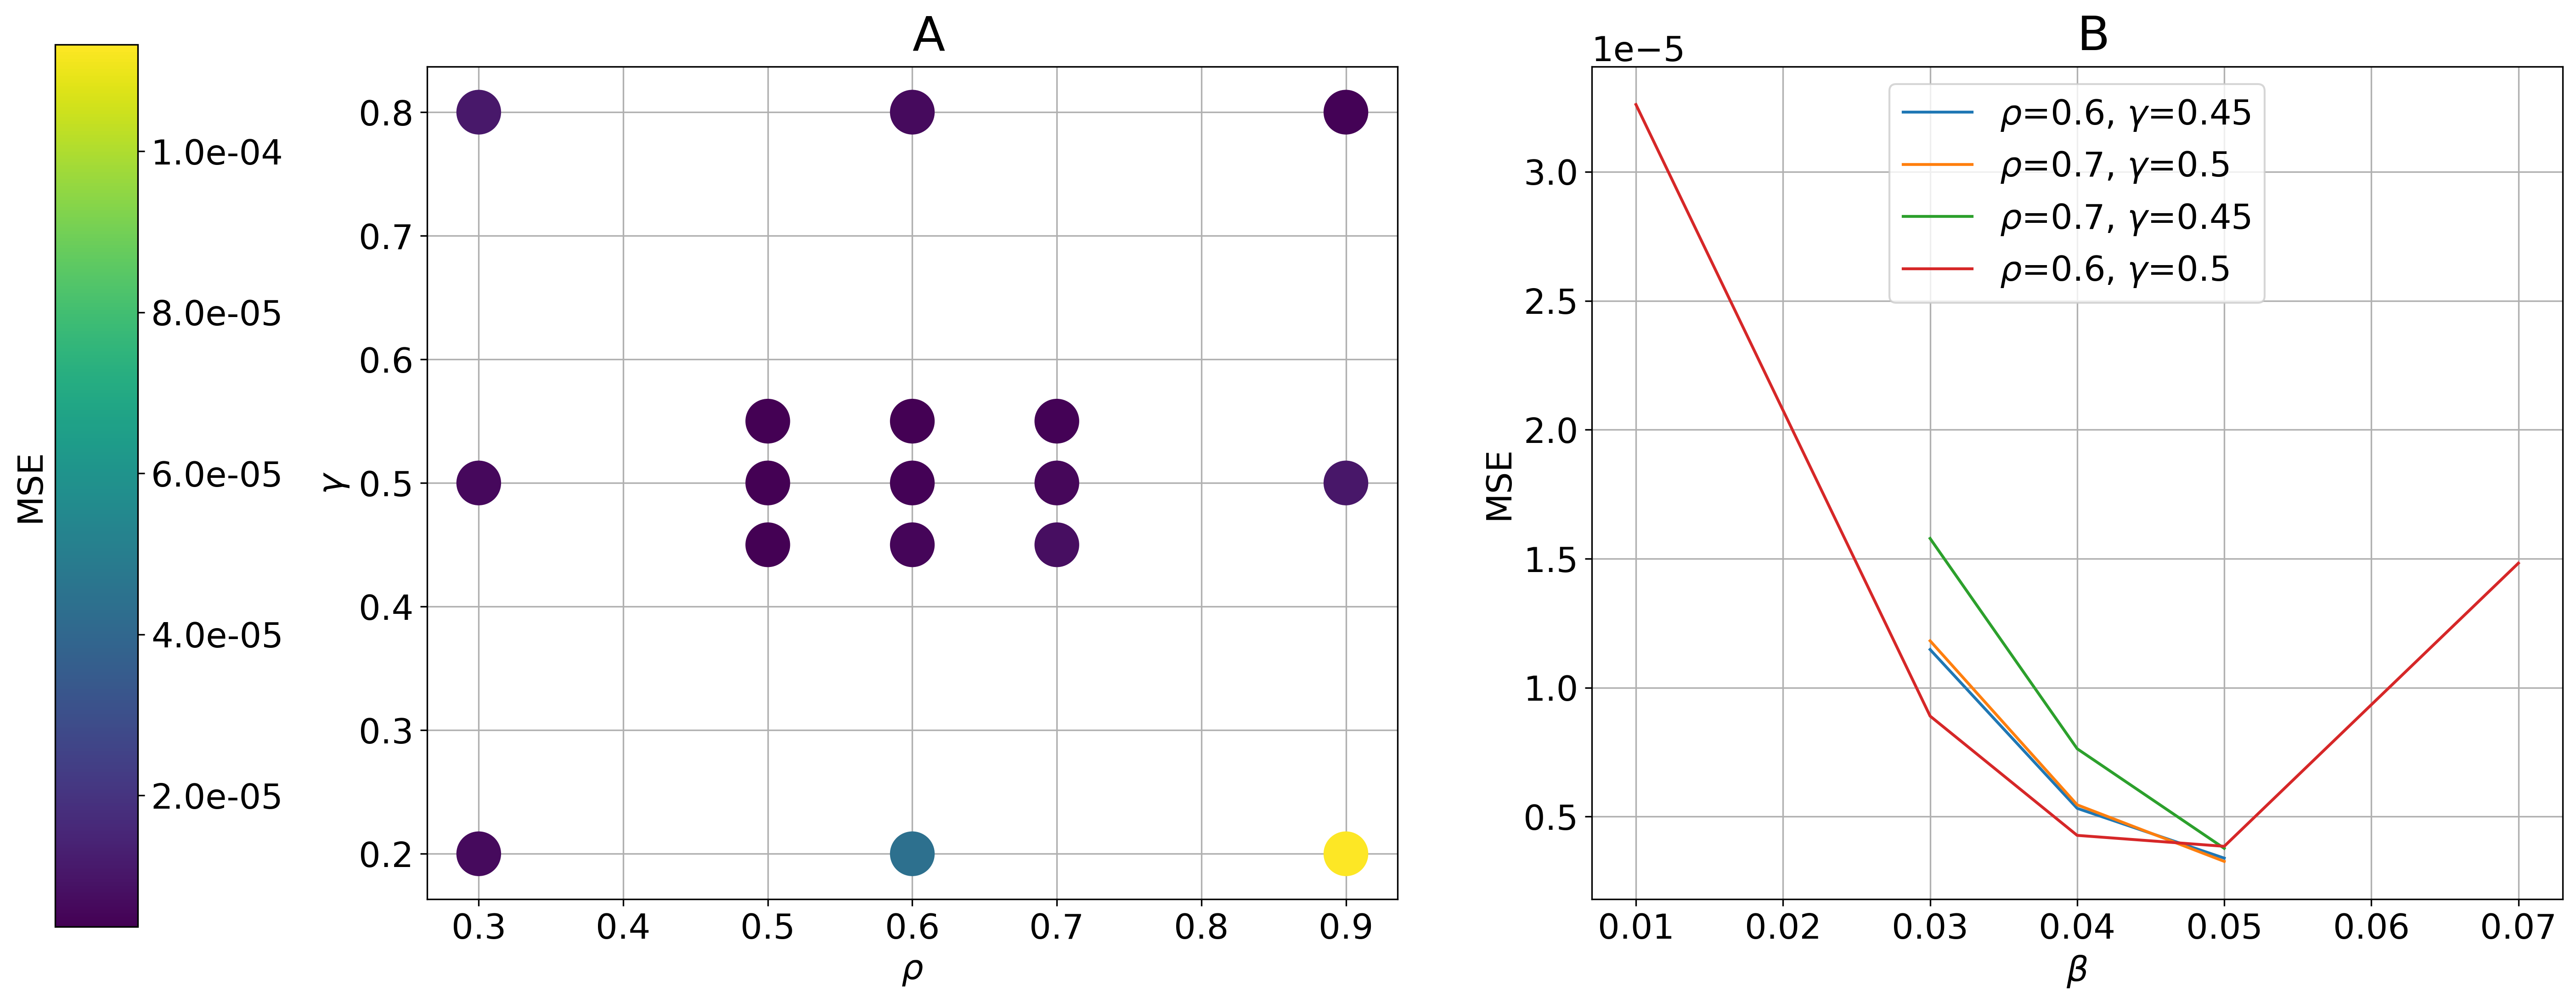

In [52]:
from matplotlib.ticker import StrMethodFormatter
mpl.rcParams['font.size'] = 18.0
exploration_plot_data = df[(df.beta == 0.04)] # & (df.p > 0.4) & (df.p < 0.8) & (df.gamma > 0.3) & (df.gamma < 0.7)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,8))
#ax1.set_xticks([0.5, 0.6, 0.7])
#ax1.set_yticks([0.45, 0.5, 0.55])
s = ax1.scatter(
    exploration_plot_data.p, 
    exploration_plot_data.gamma, 
    c=exploration_plot_data.mse,
    s=500,
    zorder=2
)
ax1.set_xlabel(r'$\rho$')
ax1.set_ylabel(r'$\gamma$')
ax1.grid(True)
ax1.text(.5, 1.02, "A", transform=ax1.transAxes, fontsize='25')
cbaxes = fig.add_axes([-0.01, 0.1, 0.03, 0.8])
cbar = fig.colorbar(s, ax=ax1, format='%.1e', cax=cbaxes)
cbar.ax.set_ylabel('MSE', rotation=90)
cbar.ax.yaxis.set_label_position('left')

for (p,gamma) in [[0.6,0.45], [0.7,0.5], [0.7,0.45], [0.6,0.5]]:
    beta_plot_data = df[(df.p == p) & (df.gamma == gamma)].sort_values(by='beta')
    ax2.plot(beta_plot_data.beta, beta_plot_data.mse, label=r'$\rho$={}, $\gamma$={}'.format(p,gamma))
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax2.grid(True)
ax2.legend(loc='upper center')
ax2.set_xlabel(r'$\beta$')
ax2.set_ylabel('MSE')
ax2.text(.5, 1.02, "B", transform=ax2.transAxes, fontsize='25')